In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, LogNorm
import astropy.units as au
import astropy.constants as ac

import functions as fct

$$
\nu = 8.7\times 10^{15}\ \mathrm{cm}^2\, \mathrm{s}^{-1}\\
\eta = 37.8\ \mathrm{cm}^2\,\mathrm{s}^{-1}\\

n = 10\ \mathrm{cm}^{-3}\\
m = 1.6\times 10^{-24}\ \mathrm{g}\\
T = 5\times 10^3\ \mathrm{K}\\
\gamma = \frac53\\
\beta = 0.05\\
\vartheta = 0.4
$$

In [3]:
# Values assumed from Schober et al. 2013

visc = 8.7e15*au.cm**2/au.s
magn_resist = 37.8*au.cm**2/au.s

mean_part_dens = 10/au.cm**3
m_part = 1.6e-24*au.gram
rho = m_part*mean_part_dens
T = 5e3*au.K
adiab = 5/3
beta = 0.05 # part of turbulent energy in kin energy
theta = 0.4
Mach_num = 2.

age_univ = (13.787e9*au.year).to(au.Myr)

In [4]:
print(f'Prandtl number = {fct.Prandtl_num(visc,magn_resist):.1e}')

Prandtl number = 2.3e+14


In [5]:
def comp_values(L,V,nu,eta,l_nu,Gam,time,B_nusat,t_L):
    B_comp = 1e-20*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)
    print(f'L = {L.to('parsec').value:.1e} pc')
    print(f'V = {V.to(au.km/au.s).value:.1e} km/s')
    print(f'Re = {(fct.Reynold(L,V,nu)).decompose():.1e}')
    print(f'Rm = {fct.magn_Reynold(L,V,eta).decompose():.1e}')
    print(f'l_nu = {l_nu.to('parsec').value:.1e} pc')
    print(f'Gamma = {Gam.to(1/au.megayear).value:.1e} 1/Myr')
    print(f't_nu = {fct.t_nu_f(time,B_nusat,fct.B_nu_t(time,B_comp,Gam)).to('megayear').value:.1e} Myr')
    print(f't_L = {t_L.to('megayear').value:.1e} Myr')
    print(f'B_nu_sat = {fct.B_nu_sat(l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second)).value:.1e} G')
    print(f'B_L_sat = {fct.B_L_sat(rho,V,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second)).value:.1e} G')

In [6]:
def plot_B_L_t(time,B_nu_0,B_t,file_name=False,title=False,ylim_low=1e-63,ylim_up=1e-5):
    # Colormap and normalization
    cmap = plt.get_cmap('viridis_r')
    norm = LogNorm(vmin=np.min(B_nu_0.value), vmax=np.max(B_nu_0.value))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8,6))

    # Plot each line with color
    for B0, B in zip(B_nu_0.value, B_t):
        ax.plot(time, B, color=cmap(norm(B0)))

    ax.set_xlabel(r'$t$ [Myr]')
    ax.set_ylabel(r'$B_L(t)$ [G]')
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.grid(axis='x')
    ax.set_xlim(time[0].value,time[-1].value)
    ax.set_ylim(ylim_low,ylim_up)

    ax.plot([age_univ.value]*2,[ylim_low,ylim_up], ls='--', color='gray')

    if title != False:
        ax.set_title(title)

    # Create a ScalarMappable for the colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Attach the colorbar to the Axes explicitly
    fig.colorbar(sm, ax=ax, label=r"$B_{\nu,0}$ [G]")

    if file_name != False:
        plt.savefig('plots/'+file_name, format='png', dpi=300)
    else:
        plt.show()


def plot_B_nu(time,B_nu_0,Gam,B_nusat,file_name=False, title=False, ylim_low=1e-52, ylim_up=1e-7):
     # Colormap and normalization
    cmap = plt.get_cmap('viridis_r')
    norm = LogNorm(vmin=np.min(B_nu_0.value), vmax=np.max(B_nu_0.value))

    fig, ax = plt.subplots(figsize=(8,6))

    B_nu = []*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

    for B0 in B_nu_0:
        B_nu = fct.B_nu_t(time,B0,Gam)
        t_nu = fct.t_nu_f(time,B_nusat,B_nu)
        B_nu = np.append(B_nu[time<t_nu], [B_nusat]*len(time[time>=t_nu]))
        ax.plot(time, B_nu, color=cmap(norm(B0.value)))

    ax.set_xlabel(r'$t$ [Myr]')
    ax.set_ylabel(r'$B_{\nu}(t)$ [G]')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(ylim_low,ylim_up)
    ax.set_xlim(time[0].value,10)

    if title != False:
        ax.set_title(title)

    # Create a ScalarMappable for the colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Attach the colorbar to the Axes explicitly
    fig.colorbar(sm, ax=ax, label=r"$B_{\nu,0}$ [G]")

    if file_name != False:
        plt.savefig('plots/'+file_name, format='png', dpi=300)
    else:
        plt.show()

### Spherical galaxy

In [7]:
# Values for spherical Galaxy
R_sph = 1e3*au.parsec
Mass_tot = 1e9*ac.M_sun # determined from radius, temperature and density

/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


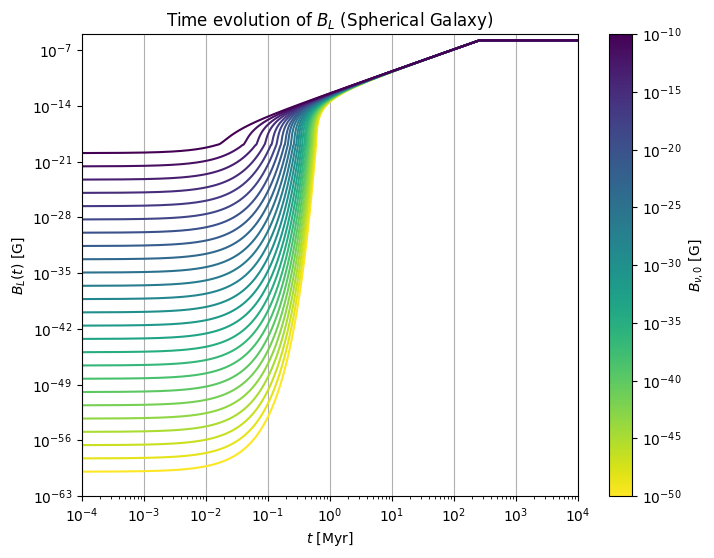

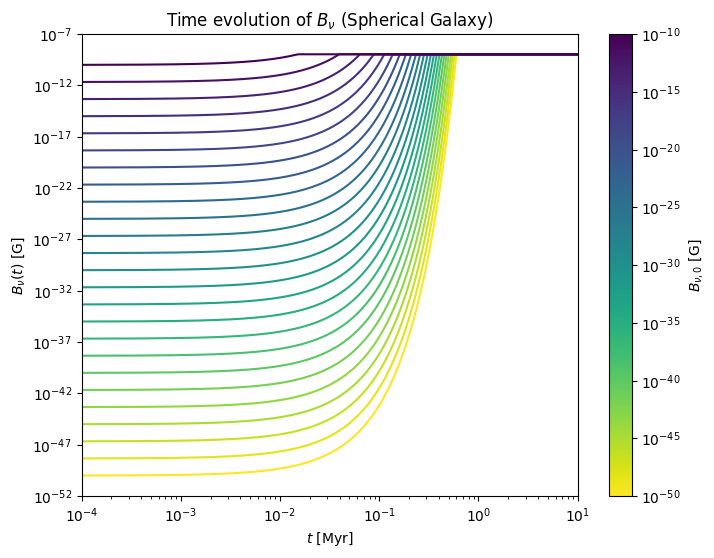

In [8]:
time = np.logspace(-4,4,1000)*au.megayear

B_nu_0 = np.logspace(-50,-10,25)*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

# Often used values
L = R_sph
V = fct.V_acc(beta,fct.c_s(adiab,T,m_part)).to(au.km/au.s)
Re = fct.Reynold(L,V,visc)
l_nu = fct.visc_scale(L,theta,Re).to('parsec')
Gam = fct.Gamma(L,V,theta,Re)
B_nusat = fct.B_nu_sat(l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))

B_t = np.zeros((len(B_nu_0),len(time)))

# Funktionen nutzen
for i,B0 in enumerate(B_nu_0):
    t_nu = fct.t_nu_f(time,B_nusat,fct.B_nu_t(time,B0,Gam))
    B_Lsat = fct.B_L_sat(rho,V,Mach_num)
    B_Lnl = fct.B_L_nl(time,t_nu,l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
    t_L = fct.t_L_f(time,B_Lsat,B_Lnl)
    B_t[i] = fct.B_L_t(time,t_nu,t_L,B0,l_nu,L,rho,V,theta,Mach_num,Gam)


# Kriege ich gleiche Werte für Dinge raus?
# comp_values(L,V,visc,magn_resist,l_nu,Gam,time,B_nusat,t_L,)

#PLOTS
plot_B_L_t(time,B_nu_0,B_t,'time_BL_Bnu0_sph.png',r'Time evolution of $B_L$ (Spherical Galaxy)')

# =======================
# Create figure and axes
plot_B_nu(time,B_nu_0,Gam,B_nusat,'time_Bnu_B_nu0_sph.png',r'Time evolution of $B_\nu$ (Spherical Galaxy)')

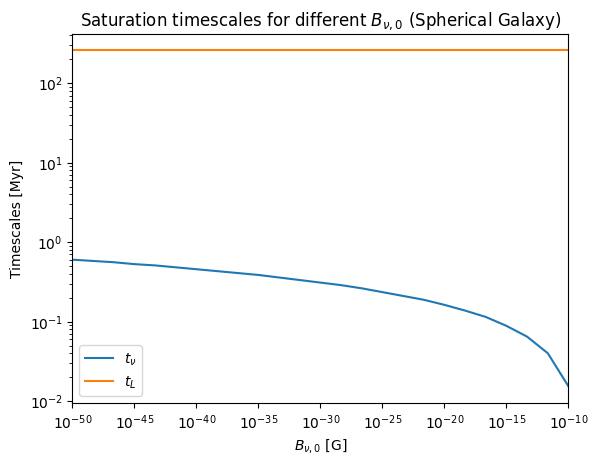

In [9]:
t_nu_arr = np.zeros(len(B_nu_0))*au.megayear
t_L_arr = np.zeros(len(B_nu_0))*au.megayear

for i, B0 in enumerate(B_nu_0):
    B_nu = fct.B_nu_t(time,B0,Gam)
    t_nu = fct.t_nu_f(time,B_nusat,B_nu)
    t_nu_arr[i] = t_nu
    B_Lsat = fct.B_L_sat(rho,V,Mach_num)
    B_Lnl = fct.B_L_nl(time,t_nu,l_nu,L,rho,V,theta,Mach_num)
    t_L_arr[i] = fct.t_L_f(time,B_Lsat,B_Lnl)

plt.plot(B_nu_0,t_nu_arr, label=r'$t_{\nu}$')
plt.plot(B_nu_0,t_L_arr, label=r'$t_L$')
plt.loglog()

plt.xlabel(r'$B_{\nu,0}$ [G]')
plt.ylabel(r'Timescales [Myr]')

plt.xlim(np.min(B_nu_0.value),np.max(B_nu_0.value))

plt.legend()

plt.title(r'Saturation timescales for different $B_{\nu,0}$ (Spherical Galaxy)')

plt.savefig('plots/tnu_tL_B_nu_0_sph.png', format='png', dpi=300)

### Disk-like galaxy

In [10]:
R_disk = 2.4e3*au.parsec
H_disk = 0.1*R_disk

/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


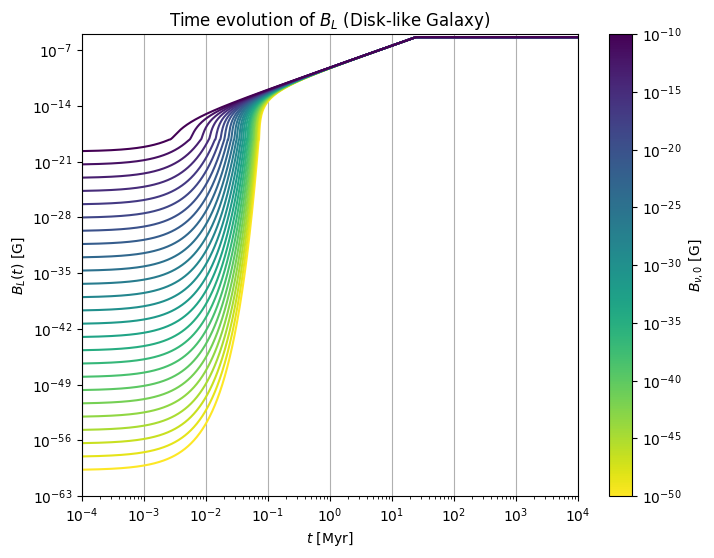

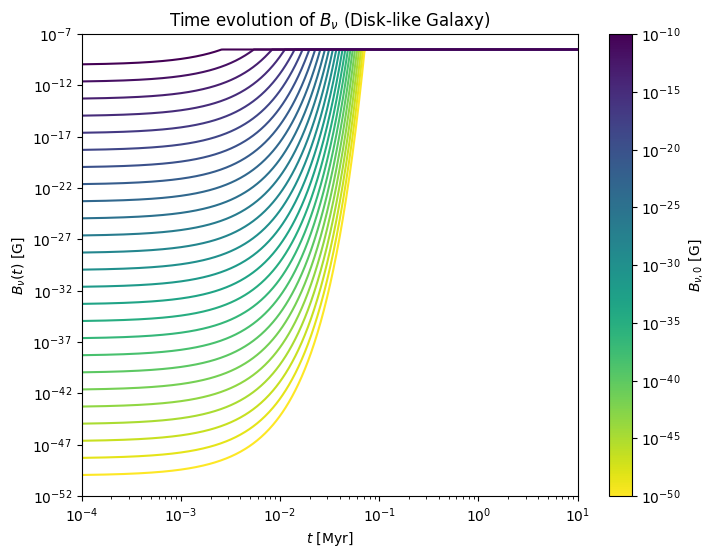

In [11]:
time = np.logspace(-4,4,1000)*au.megayear

B_nu_0 = np.logspace(-50,-10,25)*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

# Often used values
L = H_disk
V_K = fct.V_Kepler(mean_part_dens,m_part,R_disk,H_disk)
V = fct.V_acc(beta,fct.c_s(adiab,T,m_part),False,V_K).to(au.km/au.s)
Re = fct.Reynold(L,V,visc)
l_nu = fct.visc_scale(L,theta,Re).to('parsec')
Gam = fct.Gamma(L,V,theta,Re)
B_nusat = fct.B_nu_sat(l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
B_Lsat = fct.B_L_sat(rho,V,Mach_num)

B_t = np.zeros((len(B_nu_0),len(time)))

# Funktionen nutzen
for i,B0 in enumerate(B_nu_0):
    t_nu = fct.t_nu_f(time,B_nusat,fct.B_nu_t(time,B0,Gam))
    B_Lnl = fct.B_L_nl(time,t_nu,l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
    t_L = fct.t_L_f(time,B_Lsat,B_Lnl)
    B_t[i] = fct.B_L_t(time,t_nu,t_L,B0,l_nu,L,rho,V,theta,Mach_num,Gam)

# Kriege ich gleiche Werte für Dinge raus?
# comp_values(L,V,visc,magn_resist,l_nu,Gam,time,B_nusat,t_L)

#PLOTS
plot_B_L_t(time,B_nu_0,B_t,'time_BL_Bnu0_disk.png',r'Time evolution of $B_L$ (Disk-like Galaxy)')

# =======================
# Create figure and axes
plot_B_nu(time,B_nu_0,Gam,B_nusat,'time_Bnu_B_nu0_disk.png',r'Time evolution of $B_\nu$ (Disk-like Galaxy)')

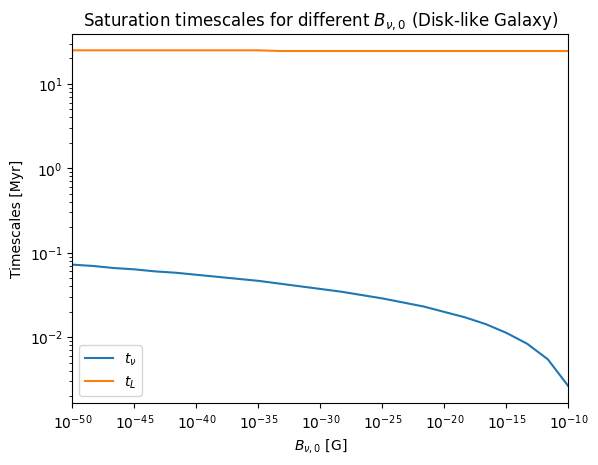

In [12]:
t_nu_arr = np.zeros(len(B_nu_0))*au.megayear
t_L_arr = np.zeros(len(B_nu_0))*au.megayear

for i, B0 in enumerate(B_nu_0):
    B_nu = fct.B_nu_t(time,B0,Gam)
    t_nu = fct.t_nu_f(time,B_nusat,B_nu)
    t_nu_arr[i] = t_nu
    B_Lsat = fct.B_L_sat(rho,V,Mach_num)
    B_Lnl = fct.B_L_nl(time,t_nu,l_nu,L,rho,V,theta,Mach_num)
    t_L_arr[i] = fct.t_L_f(time,B_Lsat,B_Lnl)

plt.plot(B_nu_0,t_nu_arr, label=r'$t_{\nu}$')
plt.plot(B_nu_0,t_L_arr, label=r'$t_L$')
plt.loglog()

plt.xlabel(r'$B_{\nu,0}$ [G]')
plt.ylabel(r'Timescales [Myr]')

plt.xlim(np.min(B_nu_0.value),np.max(B_nu_0.value))

plt.legend()

plt.title(r'Saturation timescales for different $B_{\nu,0}$ (Disk-like Galaxy)')

plt.savefig('plots/tnu_tL_B_nu_0_disk.png', format='png', dpi=300)

In [13]:
from astropy.cosmology import Planck18, z_at_value
def time_to_redshift(t):
    # cosmic age → redshift
    z = z_at_value(Planck18.age, t)
    return z

# print(time_to_redshift((0.366e3)*au.Myr))
print(time_to_redshift((366)*au.Myr))
print(time_to_redshift((1.17e3)*au.Myr))
print(time_to_redshift((2.1e3)*au.Myr))


12.016444488548087 redshift
5.0024181653909165 redshift
3.055933404021297 redshift


In [14]:
e = 4.803204e-10*au.cm**(3/2)*au.g**(1/2)/au.s
r_c = np.power(e,2)/(ac.k_B*T)

l_mfp = 1/(mean_part_dens*np.power(r_c,2))

print(l_mfp.to('parsec'))

# 1.1e-5 pc for sphere
# 3.8e-6 pc for disk

2.9015623003325084e-07 pc


## $t_\nu$ and $\vec B_{\mathrm{sat},\nu}$ with different parameters

In [15]:
# Values for spherical Galaxy
R_sph = 1e3*au.parsec
Mass_tot = 1e9*ac.M_sun # determined from radius, temperature and density

In [16]:
def compute_point(
    *, beta, theta, Mach, B0,
    L, rho, visc, time, adiab, T, m_part
):
    V = fct.V_acc(beta, fct.c_s(adiab, T, m_part)).to(au.km/au.s)
    Re = fct.Reynold(L, V, visc).decompose()
    l_nu = fct.visc_scale(L, theta, Re).to("parsec")

    B_sat_L = fct.B_L_sat(rho, V, Mach)
    B_sat_nu = fct.B_nu_sat(l_nu, L, rho, V, theta, Mach)

    Gamma = fct.Gamma(L, V, theta, Re).to(1 / au.megayear)
    B_nu = fct.B_nu_t(time, B0, Gamma)

    t_nu = fct.t_nu_f(time, B_nusat, B_nu)
    B_Lnl = fct.B_L_nl(time, t_nu, l_nu, L, rho, V, theta, Mach)
    t_L = fct.t_L_f(time, B_sat_L, B_Lnl)

    return (
        t_nu.to("megayear"),
        t_L.to("megayear"),
        B_sat_nu.to(B0.unit),
        B_sat_L.to(B0.unit),
    )


def run_scan(
    *,
    scan_arr,
    x_arr,
    axes,
    col,
    param_fn,
    B_nu0,
    B0_test,
    cmap,
    norm,
):
    for B0 in B_nu0:
        t_nu = np.zeros(len(scan_arr)) * au.megayear
        t_L  = np.zeros(len(scan_arr)) * au.megayear
        B_sn = np.zeros(len(scan_arr)) * B0.unit
        B_sL = np.zeros(len(scan_arr)) * B0.unit

        color = cmap(norm(B0.value))

        for i, x in enumerate(scan_arr):
            params = param_fn(x)
            t_nu[i], t_L[i], B_sn[i], B_sL[i] = compute_point(
                B0=B0, **params
            )

        axes[0, col].plot(x_arr, t_nu, color=color)
        axes[1, col].plot(x_arr, t_L,  color=color)

        if B0 == B0_test:
            axes[2, col].plot(x_arr, B_sn, color=color)
            axes[3, col].plot(x_arr, B_sL, color=color)


def make_beta_params(
    *, theta, Mach, L, rho, visc, time, adiab, T, m_part
):
    def beta_params(beta):
        return dict(
            beta=beta,
            theta=theta,
            Mach=Mach,
            L=L, rho=rho, visc=visc,
            time=time, adiab=adiab, T=T, m_part=m_part,
        )
    return beta_params

def make_theta_params(
    *, beta, L, rho, visc, time, adiab, T, m_part
):
    def theta_params(theta):
        Mach = 0.4 if theta > 0.45 else 2
        return dict(
            beta=beta,
            theta=theta,
            Mach=Mach,
            L=L, rho=rho, visc=visc,
            time=time, adiab=adiab, T=T, m_part=m_part,
        )
    return theta_params

def make_mach_params(
    *, beta, L, rho, visc, time, adiab, T, m_part
):
    def mach_params(Mach):
        theta = 1/2 if Mach < 1 else 1/3
        return dict(
            beta=beta,
            theta=theta,
            Mach=Mach,
            L=L, rho=rho, visc=visc,
            time=time, adiab=adiab, T=T, m_part=m_part,
        )
    return mach_params

/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


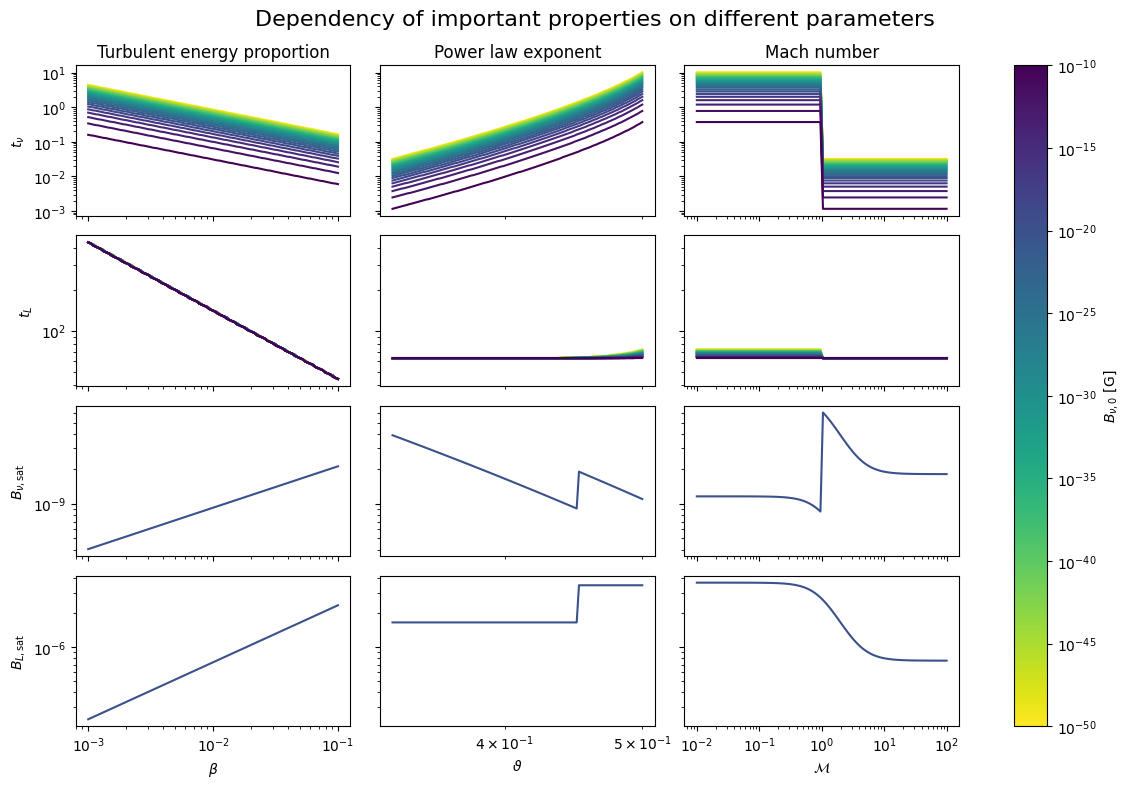

In [17]:
beta_arr = np.logspace(-3,-1,100)
theta_arr = np.linspace(1/3,1/2,100) # incompr Kolmogorov to highly compressable Burger
M_arr = np.logspace(-2,2,100)
B_nu0 = np.logspace(-50,-10,25)*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

B0_test = 1e-20*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

# Colormap and normalization
cmap = plt.get_cmap('viridis_r')
norm = LogNorm(vmin=np.min(B_nu0.value), vmax=np.max(B_nu0.value))

# Initialise plot
fig, axes = plt.subplots(4, 3, figsize=(12, 8), sharex='col', sharey='row')

beta_params = make_beta_params(
    theta=theta,
    Mach=Mach_num,
    L=L, rho=rho, visc=visc,
    time=time, adiab=adiab, T=T, m_part=m_part,
)

run_scan(
    scan_arr=beta_arr,
    x_arr=beta_arr,
    col=0,
    axes=axes,
    param_fn=beta_params,
    B_nu0=B_nu0,
    B0_test=B0_test,
    cmap=cmap,
    norm=norm,
)

theta_params = make_theta_params(
    beta=beta,
    L=L, rho=rho, visc=visc,
    time=time, adiab=adiab, T=T, m_part=m_part,
)

run_scan(
    scan_arr=theta_arr,
    x_arr=theta_arr,
    col=1,
    axes=axes,
    param_fn=theta_params,
    B_nu0=B_nu0,
    B0_test=B0_test,
    cmap=cmap,
    norm=norm,
)

mach_params = make_mach_params(
    beta=beta,
    L=L, rho=rho, visc=visc,
    time=time, adiab=adiab, T=T, m_part=m_part,
)

run_scan(
    scan_arr=M_arr,
    x_arr=M_arr,
    col=2,
    axes=axes,
    param_fn=mach_params,
    B_nu0=B_nu0,
    B0_test=B0_test,
    cmap=cmap,
    norm=norm,
)

axes[3,0].set_xlabel(r'$\beta$')
axes[3,1].set_xlabel(r'$\vartheta$')
axes[3,2].set_xlabel(r'$\mathcal{M}$')

axes[0,0].set_ylabel(r'$t_\nu$')
axes[1,0].set_ylabel(r'$t_L$')
axes[2,0].set_ylabel(r'$B_{\nu,\mathrm{sat}}$')
axes[3,0].set_ylabel(r'$B_{L,\mathrm{sat}}$')

axes[0,2].set_yscale('log')
axes[1,2].set_yscale('log')
axes[2,2].set_yscale('log')
axes[3,2].set_yscale('log')

axes[3,0].set_xscale('log')
axes[3,1].set_xscale('log')
axes[3,2].set_xscale('log')

fig.suptitle('Dependency of important properties on different parameters',fontsize=16)
axes[0,0].set_title('Turbulent energy proportion')
axes[0,1].set_title('Power law exponent')
axes[0,2].set_title('Mach number')

# Create a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.tight_layout()

# Attach the colorbar to the Axes explicitly
fig.colorbar(sm, ax=axes, label=r"$B_{\nu,0}$ [G]")


plt.savefig('plots/par_diff.png',format='png',dpi=300)

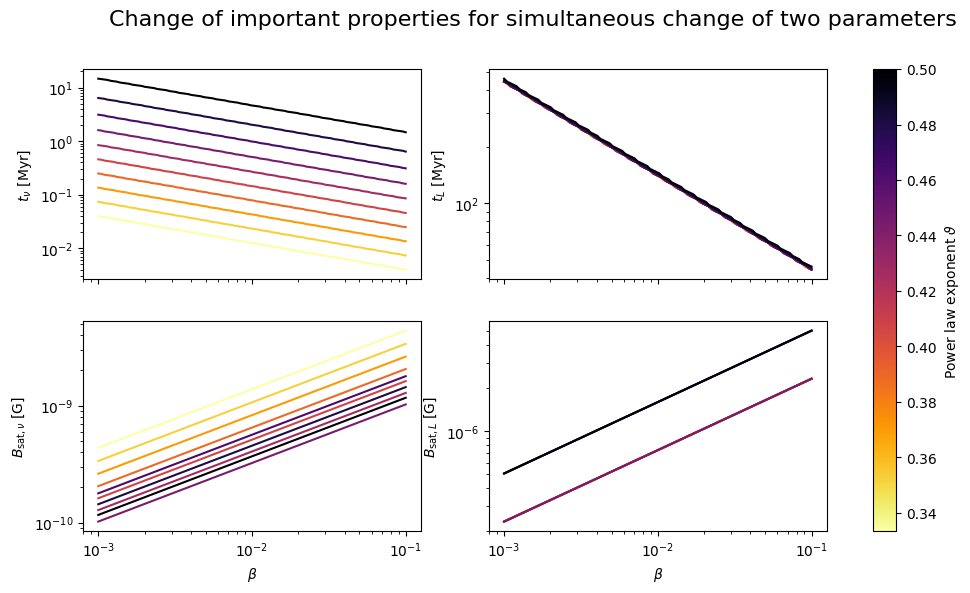

In [18]:
# Both beta and theta

# theta should lead to Re^{1/3} to Re^{1/2} so with (1-theta)/(1+theta)
theta_arr_new =np.linspace(1/3,1/2,10)

# Colormap and normalization
cmap = plt.get_cmap('inferno_r')
norm = Normalize(vmin=np.min(theta_arr_new), vmax=np.max(theta_arr_new))

# Initialise plot
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex='col')#, sharey='row')

t_nu_arr = np.zeros((len(beta_arr)))*au.megayear
t_L_arr = np.zeros((len(beta_arr)))*au.megayear
B_sat_nu = np.zeros(len(beta_arr))*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)
B_sat_L = np.zeros(len(beta_arr))*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

for t in theta_arr_new:
    if t > 0.45:
        Mach = 0.3
    else:
        Mach = 2
    for i, b in enumerate(beta_arr):
        V = fct.V_acc(b,fct.c_s(adiab,T,m_part)).to(au.km/au.s)
        R = fct.Reynold(L,V,visc).decompose()
        l_nu = fct.visc_scale(L,t,Re).to('parsec')
        B_sat_L[i] = fct.B_L_sat(rho,V,Mach).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
        B_sat_nu[i] = fct.B_nu_sat(l_nu,L,rho,V,t,Mach).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
        B_nu = fct.B_nu_t(time,B0_test,fct.Gamma(L,V,t,Re)).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
        t_nu_arr[i] = fct.t_nu_f(time,B_nusat,B_nu)
        t_L_arr[i] = fct.t_L_f(time,B_sat_L[i],fct.B_L_nl(time,t_nu_arr[i],l_nu, L, rho, V, t, Mach))

    ax[0,0].plot(beta_arr,t_nu_arr, color=cmap(norm(t)))
    ax[0,1].plot(beta_arr,t_L_arr, color=cmap(norm(t)))
    ax[1,0].plot(beta_arr,B_sat_nu, color=cmap(norm(t)))
    ax[1,1].plot(beta_arr,B_sat_L, color=cmap(norm(t)))

#ax[0,0].plot(beta_arr,[age_univ.value]*len(beta_arr), ls = '--', color='gray')
#ax[0,1].plot(beta_arr,[age_univ.value]*len(beta_arr), ls = '--', color='gray')

ax[0,0].set_ylabel(r'$t_{\nu}$ [Myr]')
ax[0,1].set_ylabel(r'$t_{L}$ [Myr]')
ax[1,0].set_ylabel(r'$B_{\mathrm{sat},\nu}$ [G]')
ax[1,1].set_ylabel(r'$B_{\mathrm{sat},L}$ [G]')
ax[1,0].set_xlabel(r'$\beta$')
ax[1,1].set_xlabel(r'$\beta$')

ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')

ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')

# Create a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# plt.tight_layout()

fig.suptitle('Change of important properties for simultaneous change of two parameters', fontsize=16)

# Attach the colorbar to the Axes explicitly
fig.colorbar(sm, ax=ax, label=r"Power law exponent $\vartheta$")

plt.savefig('plots/diff_beta_theta.png',format='png',dpi=300)


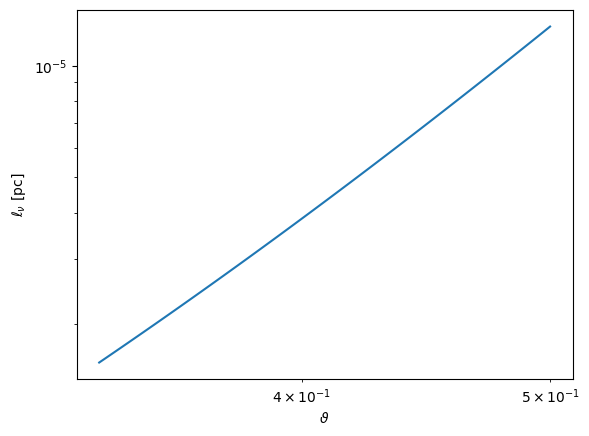

In [19]:
l_nu_arr = np.array([]*len(theta_arr))*au.parsec

for i, t in enumerate(theta_arr):
    V = fct.V_acc(beta,fct.c_s(adiab,T,m_part))
    R = fct.Reynold(L,V,visc)
    l_nu_arr = np.append(l_nu_arr, fct.visc_scale(L,t,Re))

plt.plot(theta_arr,l_nu_arr)
plt.loglog()

plt.ylabel(r'$\ell_{\nu}$ [pc]')
plt.xlabel(r'$\vartheta$')

plt.show()

## Aufbau turbulente Kaskade

#### Kirk et al. (2025)
$$

$$

### Spherical Galaxy

In [20]:
# Spherical galaxy
L = R_sph
V = fct.V_acc(beta,fct.c_s(adiab, T, m_part))

# Eddy-turnover time:
t_eddy_to = (L/V).to('megayear')
print(t_eddy_to)
t_first_gal = 350*au.megayear

257.8342179239044 Myr


In [21]:
t_eddy_fac = np.array([1.,3.,7.,10.])
t_eto_arr = t_eddy_fac*t_eddy_to

time = np.logspace(-4,4,1000)*au.megayear
B_nu_0 = np.logspace(-300,-10,25)*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

Re = fct.Reynold(L,V,visc)
l_nu = fct.visc_scale(L,theta,Re).to('parsec')
Gam = fct.Gamma(L,V,theta,Re)
B_nusat = fct.B_nu_sat(l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
B_Lsat = fct.B_L_sat(rho,V,Mach_num)

t_nu_arr = np.zeros(len(B_nu_0))*au.megayear
t_L_arr = np.zeros(len(B_nu_0))*au.megayear

for i,B0 in enumerate(B_nu_0):
    t_nu_arr[i] = fct.t_nu_f(time,B_nusat,fct.B_nu_t(time,B0,Gam))
    B_Lnl = fct.B_L_nl(time,t_nu,l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
    t_L_arr[i] = fct.t_L_f(time,B_Lsat,B_Lnl)

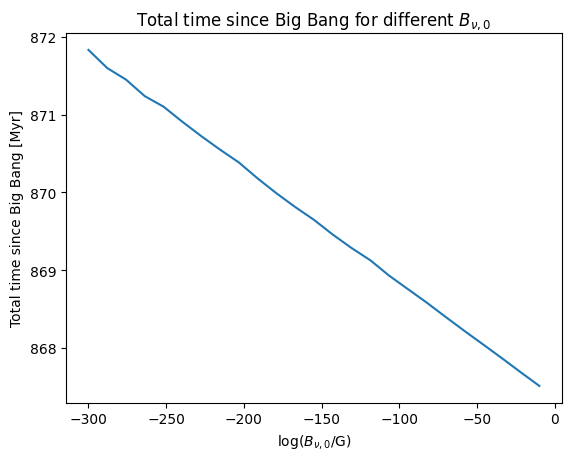

In [22]:
# PLOTTEN
time_tot = t_first_gal + t_eddy_to + t_nu_arr + t_L_arr

plt.plot(np.log10(B_nu_0.value),time_tot)
# plt.loglog()

plt.ylabel(r'Total time since Big Bang [Myr]')
plt.xlabel(r'$\log(B_{\nu,0}/\mathrm{G})$')

plt.title(r'Total time since Big Bang for different $B_{\nu,0}$')

# plt.show()
plt.savefig('plots/tot_time_B0_sph.png',format='png',dpi=300)

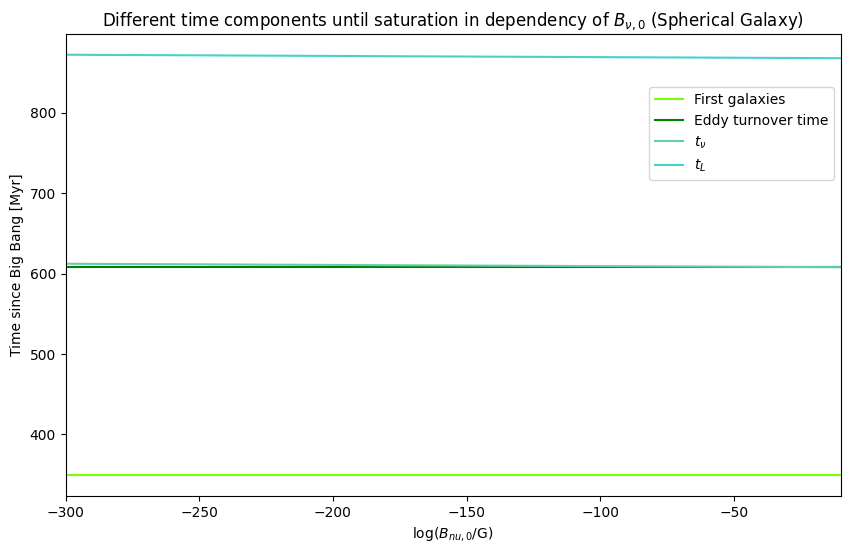

In [23]:
# Eddy-turnover time:
t_eddy_to = (L/V).to('megayear')
# Time to first galaxies (from JWST data)
t_first_gal = 350*au.megayear

l10_Bnu0 = np.log10(B_nu_0.value)

# PLOTTEN
color_times = np.array(['lawngreen','green','mediumaquamarine','mediumturquoise'])

# Create figure and axes
plt.figure(figsize=(10,6))

plt.plot([np.min(l10_Bnu0),np.max(l10_Bnu0)], [t_first_gal.value]*2, color = color_times[0], label = 'First galaxies')
plt.plot([np.min(l10_Bnu0),np.max(l10_Bnu0)], [t_first_gal.value+t_eddy_to.value]*2, color = color_times[1], label = 'Eddy turnover time')
time_nu = t_first_gal+t_eddy_to+t_nu_arr
plt.plot(l10_Bnu0, time_nu, color = color_times[2], label = r'$t_{\nu}$')
time_L = t_first_gal+t_eddy_to+t_nu_arr+t_L_arr
plt.plot(l10_Bnu0, time_L, color = color_times[3], label = r'$t_L$')

# plt.axhline(13800, linestyle='--', label="Age of Universe",color='gray',zorder=4)
# plt.axhline(1200, linestyle=':', label=r"Redshift $z = 5$",color='gray',zorder=4)

plt.xlim(np.min(l10_Bnu0),np.max(l10_Bnu0))

plt.xlabel(r'$\log(B_{nu,0}/\mathrm{G})$')
plt.ylabel(r'Time since Big Bang [Myr]')

plt.legend(bbox_to_anchor=(1.,0.9,0.,0.))

plt.title(r'Different time components until saturation in dependency of $B_{\nu,0}$ (Spherical Galaxy)')

# plt.show()
plt.savefig('plots/Change_in_time_B0.png',format='png',dpi=300)

350.0 Myr
257.8342179239044 Myr 2578.342179239044 Myr
0.002614673211801092 Myr 24.512600620333398 Myr


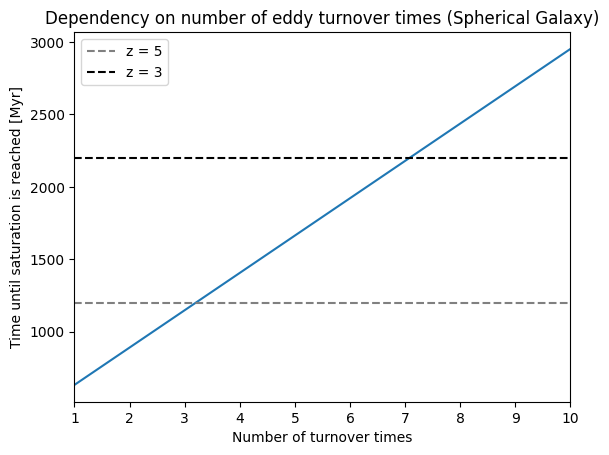

In [41]:
t_eddy_fac = np.linspace(1.,10.,1000)
t_eto_arr = t_eddy_fac*t_eddy_to

print(t_first_gal)
print(t_eto_arr[0], t_eto_arr[-1])
print(t_nu, t_L)

t_tot = t_first_gal + t_eto_arr + t_nu + t_L

plt.figure()

plt.plot(t_eddy_fac,t_tot)

# plt.plot([1,10],[age_univ.value]*2,ls='--',color='gray')
plt.plot([1,10],[1200]*2,ls='--',color='gray',label='z = 5')
plt.plot([1,10],[2200]*2,ls='--',color='black',label='z = 3')

plt.xlim(1,10)

plt.xlabel('Number of turnover times')
plt.ylabel('Time until saturation is reached [Myr]')

plt.title('Dependency on number of eddy turnover times (Spherical Galaxy)')

plt.legend()

# plt.show()
plt.savefig('plots/num_eddy_turnover_sph.png',format='png',dpi=300)

### Disk-like Galaxy

In [ ]:
L = H_disk
V_K = fct.V_Kepler(mean_part_dens,m_part,R_disk,H_disk)
V = fct.V_acc(beta,fct.c_s(adiab,T,m_part),False,V_K).to(au.km/au.s)

t_eto = fct.t_eddy_to(L,V) #.to('megayear')

In [27]:
t_eddy_fac = np.array([1.,3.,7.,10.])
t_eto_arr = t_eddy_fac*t_eddy_to

time = np.logspace(-4,4,1000)*au.megayear
B_nu_0 = np.logspace(-50,-10,25)*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

Re = fct.Reynold(L,V,visc)
l_nu = fct.visc_scale(L,theta,Re).to('parsec')
Gam = fct.Gamma(L,V,theta,Re)
B_nusat = fct.B_nu_sat(l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
B_Lsat = fct.B_L_sat(rho,V,Mach_num)

t_nu_arr = np.zeros(len(B_nu_0))*au.megayear
t_L_arr = np.zeros(len(B_nu_0))*au.megayear

for i,B0 in enumerate(B_nu_0):
    t_nu_arr[i] = fct.t_nu_f(time,B_nusat,fct.B_nu_t(time,B0,Gam))
    B_Lnl = fct.B_L_nl(time,t_nu,l_nu,L,rho,V,theta,Mach_num).to(au.gram**(1/2)/(au.centimeter**(1/2)*au.second))
    t_L_arr[i] = fct.t_L_f(time,B_Lsat,B_Lnl)

24.46657855902774 Myr
350.0 Myr
257.8342179239044 Myr 2578.342179239044 Myr
0.002614673211801092 Myr 24.512600620333398 Myr


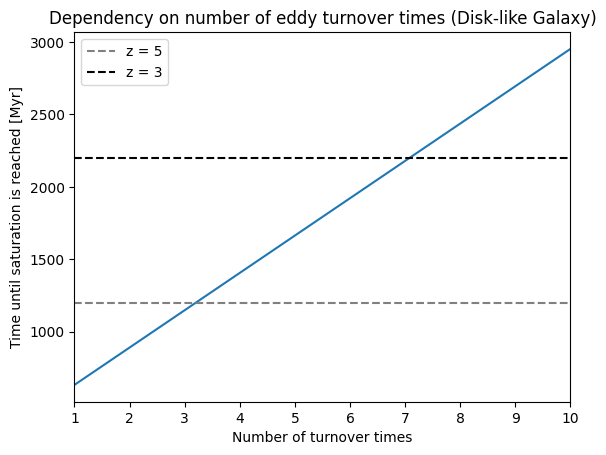

In [28]:
t_eddy_fac = np.linspace(1.,10.,1000)
t_eto_arr = t_eddy_fac*t_eddy_to

print((L/V).to('megayear'))
print(t_first_gal)
print(t_eto_arr[0], t_eto_arr[-1])
print(t_nu, t_L)

t_tot = t_first_gal + t_eto_arr + t_nu + t_L

plt.figure()

plt.plot(t_eddy_fac,t_tot)

xmin, xmax = (np.min(t_eddy_fac), np.max(t_eddy_fac))
# plt.hlines(age_univ.value,xmin,xmax,ls='--',color='gray') # Age of the universe
plt.hlines(1200,xmin,xmax,ls='--',color='gray',label='z = 5') # z=5 higher limit ordered B
plt.hlines(2200,xmin,xmax,ls='--',color='black',label='z = 3') # z=3 lower limit ordered B

plt.xlim(xmin,xmax)

plt.xlabel('Number of turnover times')
plt.ylabel('Time until saturation is reached [Myr]')

plt.title('Dependency on number of eddy turnover times (Disk-like Galaxy)')

plt.legend()

# plt.show()
plt.savefig('plots/num_eddy_turnover_disk.png',format='png',dpi=300)

In [29]:
def plot_B_L_t(time,B_nu_0,B_t,file_name=False,title=False,ylim_low=1e-63,ylim_up=1e-5):
    # Colormap and normalization
    cmap = plt.get_cmap('viridis_r')
    norm = LogNorm(vmin=np.min(B_nu_0.value), vmax=np.max(B_nu_0.value))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8,6))

    # Plot each line with color
    for B0, B in zip(B_nu_0.value, B_t):
        ax.plot(time, B, color=cmap(norm(B0)))

    ax.set_xlabel(r'$t$ [Myr]')
    ax.set_ylabel(r'$B_L(t)$ [G]')
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.grid(axis='x')
    ax.set_xlim(time[0].value,time[-1].value)
    ax.set_ylim(ylim_low,ylim_up)

    ax.plot([age_univ.value]*2,[ylim_low,ylim_up], ls='--', color='gray')

    if title != False:
        ax.set_title(title)

    # Create a ScalarMappable for the colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Attach the colorbar to the Axes explicitly
    fig.colorbar(sm, ax=ax, label=r"$B_{\nu,0}$ [G]")

    if file_name != False:
        plt.savefig('plots/'+file_name, format='png', dpi=300)
    else:
        plt.show()

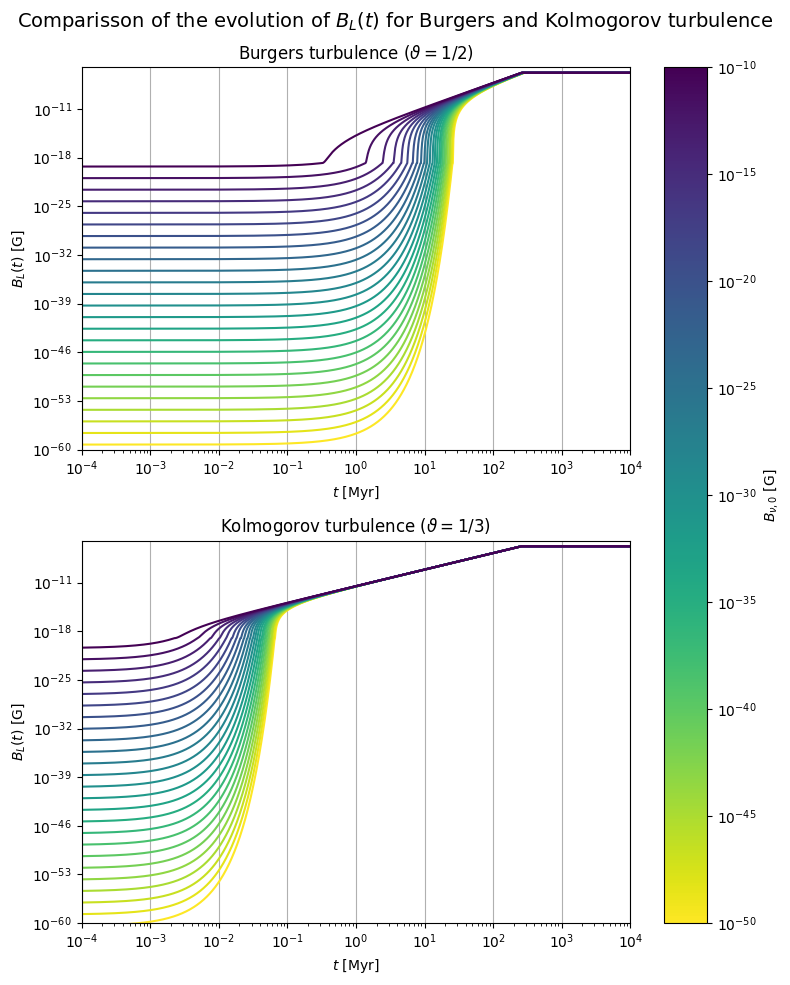

In [30]:
Burgers = 1/2# Burgers turbulence
Kolmogorov =  1/3 # Kolmogorov turbulence

time = np.logspace(-4,4,1000)*au.megayear

B_nu_0 = np.logspace(-50,-10,25)*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

# Often used values
L = R_sph
V = fct.V_acc(beta,fct.c_s(adiab,T,m_part)).to(au.km/au.s)
Re = fct.Reynold(L,V,visc)
l_nu_B = fct.visc_scale(L,Burgers,Re).to('parsec')
l_nu_K = fct.visc_scale(L,Kolmogorov,Re).to('parsec')
Gam_B = fct.Gamma(L,V,Burgers,Re)
Gam_K = fct.Gamma(L,V,Kolmogorov,Re)
B_nusat_B = fct.B_nu_sat(l_nu_B,L,rho,V,Burgers,Mach_num).to(B_nu_0.unit)
B_nusat_K = fct.B_nu_sat(l_nu_K,L,rho,V,Kolmogorov,Mach_num).to(B_nu_0.unit)
B_Lsat = fct.B_L_sat(rho,V,Mach_num)

B_t_B = np.zeros((len(B_nu_0),len(time)))
B_t_K = np.zeros((len(B_nu_0),len(time)))

# Funktionen nutzen
for i,B0 in enumerate(B_nu_0):
    t_nu_B = fct.t_nu_f(time,B_nusat_B,fct.B_nu_t(time,B0,Gam_B))
    t_nu_K = fct.t_nu_f(time,B_nusat_K,fct.B_nu_t(time,B0,Gam_K))
    B_Lnl_B = fct.B_L_nl(time,t_nu_B,l_nu_B,L,rho,V,Burgers,Mach_num).to(B_nu_0.unit)
    B_Lnl_K = fct.B_L_nl(time,t_nu_K,l_nu_K,L,rho,V,Kolmogorov,Mach_num).to(B_nu_0.unit)
    t_L_B = fct.t_L_f(time,B_Lsat,B_Lnl_B)
    t_L_K = fct.t_L_f(time,B_Lsat,B_Lnl_K)
    B_t_B[i] = fct.B_L_t(time,t_nu_B,t_L_B,B0,l_nu_B,L,rho,V,Burgers,Mach_num,Gam_B)
    B_t_K[i] = fct.B_L_t(time,t_nu_K,t_L_K,B0,l_nu_K,L,rho,V,Kolmogorov,Mach_num,Gam_K)

# ============================= PLOT =============================
# Colormap and normalization
cmap = plt.get_cmap('viridis_r')
norm = LogNorm(vmin=np.min(B_nu_0.value), vmax=np.max(B_nu_0.value))

# Create figure and axes
fig, ax = plt.subplots(2, 1, figsize=(8,10))

# Plot each line with color
for i, B0 in enumerate(B_nu_0.value):
    ax[0].plot(time, B_t_B[i,:], color=cmap(norm(B0)))
    ax[1].plot(time, B_t_K[i,:], color=cmap(norm(B0)))

ax[0].set_xlabel(r'$t$ [Myr]')
ax[0].set_ylabel(r'$B_L(t)$ [G]')
ax[0].set_xscale("log")
ax[0].set_yscale("log")

ax[1].set_xlabel(r'$t$ [Myr]')
ax[1].set_ylabel(r'$B_L(t)$ [G]')
ax[1].set_xscale("log")
ax[1].set_yscale("log")

ymin, ymax = (1e-60,1e-5)

ax[0].grid(axis='x')
ax[0].set_xlim(time[0].value,time[-1].value)
ax[0].set_ylim(ymin,ymax)

ax[1].grid(axis='x')
ax[1].set_xlim(time[0].value,time[-1].value)
ax[1].set_ylim(ymin,ymax)

ax[0].vlines(age_univ.value,ymin,ymax, ls='--', color='gray')
ax[1].vlines(age_univ.value,ymin,ymax, ls='--', color='gray')

ax[0].set_title(r"Burgers turbulence $(\vartheta = 1/2)$")
ax[1].set_title(r"Kolmogorov turbulence $(\vartheta = 1/3)$")

fig.suptitle(r"Comparisson of the evolution of $B_L(t)$ for Burgers and Kolmogorov turbulence",\
             fontsize=14)

plt.tight_layout()

# Create a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Attach the colorbar to the Axes explicitly
fig.colorbar(sm, ax=ax, label=r"$B_{\nu,0}$ [G]")

plt.savefig('plots/Kolmogorov_vs_Burger.png', format='png', dpi=300)
# plt.show()


/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/3relos/.local/lib/python3.14/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


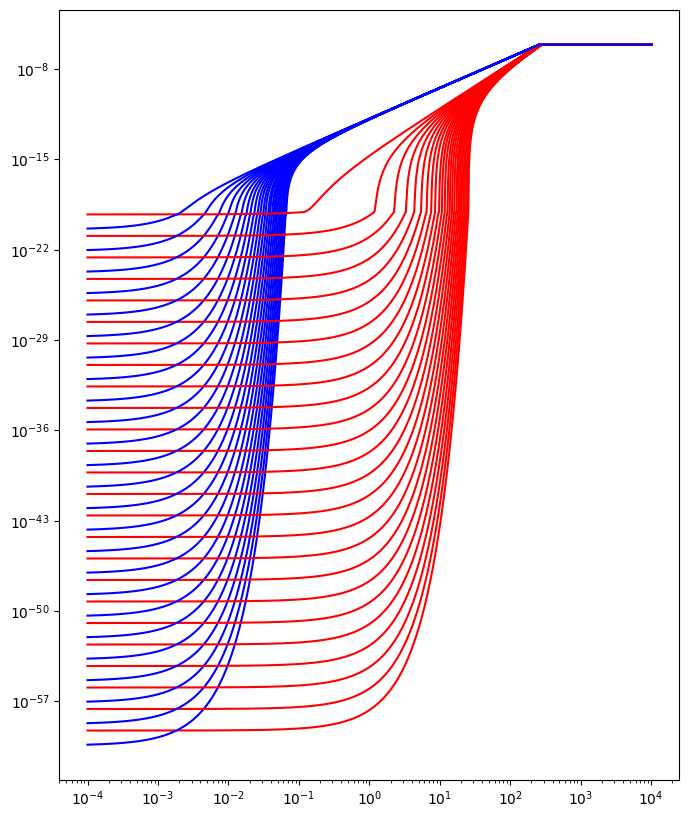

259.6655972934872 Myr 259.6655972934872 Myr


In [40]:
Burgers = 1/2# Burgers turbulence
Kolmogorov =  1/3 # Kolmogorov turbulence

Mach_num = 100

time = np.logspace(-4,4,1000)*au.megayear

B_nu_0 = np.logspace(-50,-10,25)*au.gram**(1/2)/(au.centimeter**(1/2)*au.second)

# Often used values
L = R_sph
V = fct.V_acc(beta,fct.c_s(adiab,T,m_part)).to(au.km/au.s)
Re = fct.Reynold(L,V,visc)
l_nu_B = fct.visc_scale(L,Burgers,Re).to('parsec')
l_nu_K = fct.visc_scale(L,Kolmogorov,Re).to('parsec')
Gam_B = fct.Gamma(L,V,Burgers,Re)
Gam_K = fct.Gamma(L,V,Kolmogorov,Re)
B_nusat_B = fct.B_nu_sat(l_nu_B,L,rho,V,Burgers,Mach_num).to(B_nu_0.unit)
B_nusat_K = fct.B_nu_sat(l_nu_K,L,rho,V,Kolmogorov,Mach_num).to(B_nu_0.unit)
B_Lsat = fct.B_L_sat(rho,V,Mach_num)

B_t_B = np.zeros((len(B_nu_0),len(time)))
B_t_K = np.zeros((len(B_nu_0),len(time)))

# Funktionen nutzen
for i,B0 in enumerate(B_nu_0):
    t_nu_B = fct.t_nu_f(time,B_nusat_B,fct.B_nu_t(time,B0,Gam_B))
    t_nu_K = fct.t_nu_f(time,B_nusat_K,fct.B_nu_t(time,B0,Gam_K))
    B_Lnl_B = fct.B_L_nl(time,t_nu_B,l_nu_B,L,rho,V,Burgers,Mach_num).to(B_nu_0.unit)
    B_Lnl_K = fct.B_L_nl(time,t_nu_K,l_nu_K,L,rho,V,Kolmogorov,Mach_num).to(B_nu_0.unit)
    t_L_B = fct.t_L_f(time,B_Lsat,B_Lnl_B)
    t_L_K = fct.t_L_f(time,B_Lsat,B_Lnl_K)
    B_t_B[i] = fct.B_L_t(time,t_nu_B,t_L_B,B0,l_nu_B,L,rho,V,Burgers,Mach_num,Gam_B)
    B_t_K[i] = fct.B_L_t(time,t_nu_K,t_L_K,B0,l_nu_K,L,rho,V,Kolmogorov,Mach_num,Gam_K)

# ============================= PLOT =============================
# Colormap and normalization
cmap = plt.get_cmap('viridis_r')
norm = LogNorm(vmin=np.min(B_nu_0.value), vmax=np.max(B_nu_0.value))

# Create figure and axes
fig, ax = plt.subplots(figsize=(8,10))

# Plot each line with color
for i, B0 in enumerate(B_nu_0.value):
    ax.plot(time, B_t_B[i,:], color='red')
    ax.plot(time, B_t_K[i,:], color='blue')

# ax[0].set_xlabel(r'$t$ [Myr]')
# ax[0].set_ylabel(r'$B_L(t)$ [G]')
# ax[0].set_xscale("log")
# ax[0].set_yscale("log")

# ax[1].set_xlabel(r'$t$ [Myr]')
# ax[1].set_ylabel(r'$B_L(t)$ [G]')
ax.set_xscale("log")
ax.set_yscale("log")

# ymin, ymax = (1e-60,1e-5)

# ax[0].grid(axis='x')
# ax[0].set_xlim(time[0].value,time[-1].value)
# ax[0].set_ylim(ymin,ymax)

# ax[1].grid(axis='x')
# ax[1].set_xlim(time[0].value,time[-1].value)
# ax[1].set_ylim(ymin,ymax)

# ax[0].vlines(age_univ.value,ymin,ymax, ls='--', color='gray')
# ax[1].vlines(age_univ.value,ymin,ymax, ls='--', color='gray')

# ax[0].set_title(r"Burgers turbulence $(\vartheta = 1/2)$")
# ax[1].set_title(r"Kolmogorov turbulence $(\vartheta = 1/3)$")

# fig.suptitle(r"Comparisson of the evolution of $B_L(t)$ for Burgers and Kolmogorov turbulence",\
#              fontsize=14)

# plt.tight_layout()

# # Create a ScalarMappable for the colorbar
# sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# # Attach the colorbar to the Axes explicitly
# fig.colorbar(sm, ax=ax, label=r"$B_{\nu,0}$ [G]")

# plt.savefig('plots/Kolmogorov_vs_Burger.png', format='png', dpi=300)
plt.show()


print(t_L_B, t_L_K)